In [1]:
import os
from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statistics

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import time

In [2]:
df1 = pd.read_csv("Healthy_z.csv")
df2 = pd.read_csv("A1_z.csv")

In [3]:
frames = [df1,df2]
final = pd.concat(frames)

In [4]:
y = final['Anomaly']
print(y)

0      0
1      0
2      0
3      0
4      0
      ..
645    1
646    1
647    1
648    1
649    1
Name: Anomaly, Length: 1300, dtype: int64


In [5]:
df = final.drop(['Unnamed: 0', 'Anomaly'], axis=1)
df.head()

,MAD,Median,Mean,Variance,Std,Kurtosis,Skew,Crest Factor,Impulse Factor,Shape Factor
0,4.693111,1.000400,0.353286,46.947659,6.851836,0.272563,-0.197340,2.330628,3.324152,1.426290
1,0.011154,1.120448,1.120117,0.000206,0.014344,0.920398,-0.034632,1.071222,1.071310,1.000082
2,0.188268,1.120936,1.108022,0.069256,0.263165,12.241497,-1.767512,1.740156,1.775868,1.020522
3,0.239150,1.115568,1.119472,0.087780,0.296277,-0.350448,0.102193,1.716407,1.775501,1.034429
4,0.234109,1.114836,1.119892,0.084959,0.291476,-0.261811,0.158100,1.734902,1.792702,1.033316


In [6]:
scaler = StandardScaler()

scaler.fit(df)
data = scaler.transform(df)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.3)
print(len(x_train), len(x_test), len(y_train), len(y_test))

910 390 910 390


In [8]:
train_data = tf.convert_to_tensor(x_train)
val_data = tf.convert_to_tensor(x_test)
train_labels = tf.convert_to_tensor(y_train)
val_labels = tf.convert_to_tensor(y_test)

train_dataset=tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_dataset=tf.data.Dataset.from_tensor_slices((val_data, val_labels))

train_dataset = train_dataset.batch(1)
val_dataset = val_dataset.batch(1)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-03 17:13:44.371351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-03 17:13:44.371484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(10)),
    tf.keras.layers.Reshape((10,1)),
    tf.keras.layers.Conv1D(32, kernel_size=(3), activation="relu", padding="valid"),
    tf.keras.layers.Conv1D(8, kernel_size=(3),activation="relu", padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 10, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 32)             128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 8)              776       
_________________________________________________________________
flatten (Flatten)            (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1568      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9

In [11]:
lr = 1e-2
opt = tf.keras.optimizers.Adam(lr)
metrics = [BinaryAccuracy(), Recall(), Precision()]
loss_fn=tf.keras.losses.BinaryCrossentropy()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics)

In [12]:
print(len(train_dataset))

910


In [13]:


epochs = 20
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # print(step)

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            t0=time.time()
            
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            t1=time.time()

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

            t2=time.time()

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        t3=time.time()

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        opt.apply_gradients(zip(grads, model.trainable_weights))

        t4=time.time()

        # Log every 200 batches.
        if step % 1 == 0:
            print("Fwprop time %d: %.4f",(step, float(t1-t0)))
            print("gradient calculation time %d: %.4f",(step, float(t3-t2)))
            print("loss time %d: %.4f",(step, float(t2-t1)))
            print("weight update time %d: %.4f",(step, float(t4-t3)))
            



Start of epoch 0
Fwprop time %d: %.4f (0, 0.03467583656311035)
gradient calculation time %d: %.4f (0, 0.033586978912353516)
loss time %d: %.4f (0, 0.016912221908569336)
weight update time %d: %.4f (0, 0.05098891258239746)
Fwprop time %d: %.4f (1, 0.0031890869140625)
gradient calculation time %d: %.4f (1, 0.0042040348052978516)
loss time %d: %.4f (1, 0.002234935760498047)
weight update time %d: %.4f (1, 0.003292083740234375)
Fwprop time %d: %.4f (2, 0.0025658607482910156)
gradient calculation time %d: %.4f (2, 0.0027549266815185547)
loss time %d: %.4f (2, 0.0017549991607666016)
weight update time %d: %.4f (2, 0.002836942672729492)
Fwprop time %d: %.4f (3, 0.002416849136352539)
gradient calculation time %d: %.4f (3, 0.002628803253173828)
loss time %d: %.4f (3, 0.0017189979553222656)
weight update time %d: %.4f (3, 0.002827167510986328)
Fwprop time %d: %.4f (4, 0.002275705337524414)
gradient calculation time %d: %.4f (4, 0.0024976730346679688)
loss time %d: %.4f (4, 0.0016932487487792969

KeyboardInterrupt: 

In [ ]:
start = time.time()
history = model.fit(train_data, train_labels, epochs=20, batch_size=128, validation_split=0.2)
print(time.time()-start)

Epoch 1/20
6/6 [==============================] - 1s 122ms/step - loss: 0.6822 - binary_accuracy: 0.5931 - recall_3: 0.1744 - precision_3: 0.9875 - val_loss: 0.6283 - val_binary_accuracy: 0.6758 - val_recall_3: 0.3854 - val_precision_3: 1.0000
Epoch 2/20
6/6 [==============================] - 0s 63ms/step - loss: 0.5895 - binary_accuracy: 0.7079 - recall_3: 0.4286 - precision_3: 0.9863 - val_loss: 0.4657 - val_binary_accuracy: 0.6813 - val_recall_3: 0.3958 - val_precision_3: 1.0000
Epoch 3/20
6/6 [==============================] - 0s 33ms/step - loss: 0.4275 - binary_accuracy: 0.7899 - recall_3: 0.7914 - precision_3: 0.7997 - val_loss: 0.3410 - val_binary_accuracy: 0.8242 - val_recall_3: 0.9896 - val_precision_3: 0.7540
Epoch 4/20
6/6 [==============================] - 0s 53ms/step - loss: 0.3427 - binary_accuracy: 0.8303 - recall_3: 0.9927 - precision_3: 0.7451 - val_loss: 0.3431 - val_binary_accuracy: 0.8187 - val_recall_3: 0.9896 - val_precision_3: 0.7480
Epoch 5/20
6/6 [===========

/tmp/ipykernel_1324514/3096389101.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='darkgray', linestyle='-',alpha=0.2)


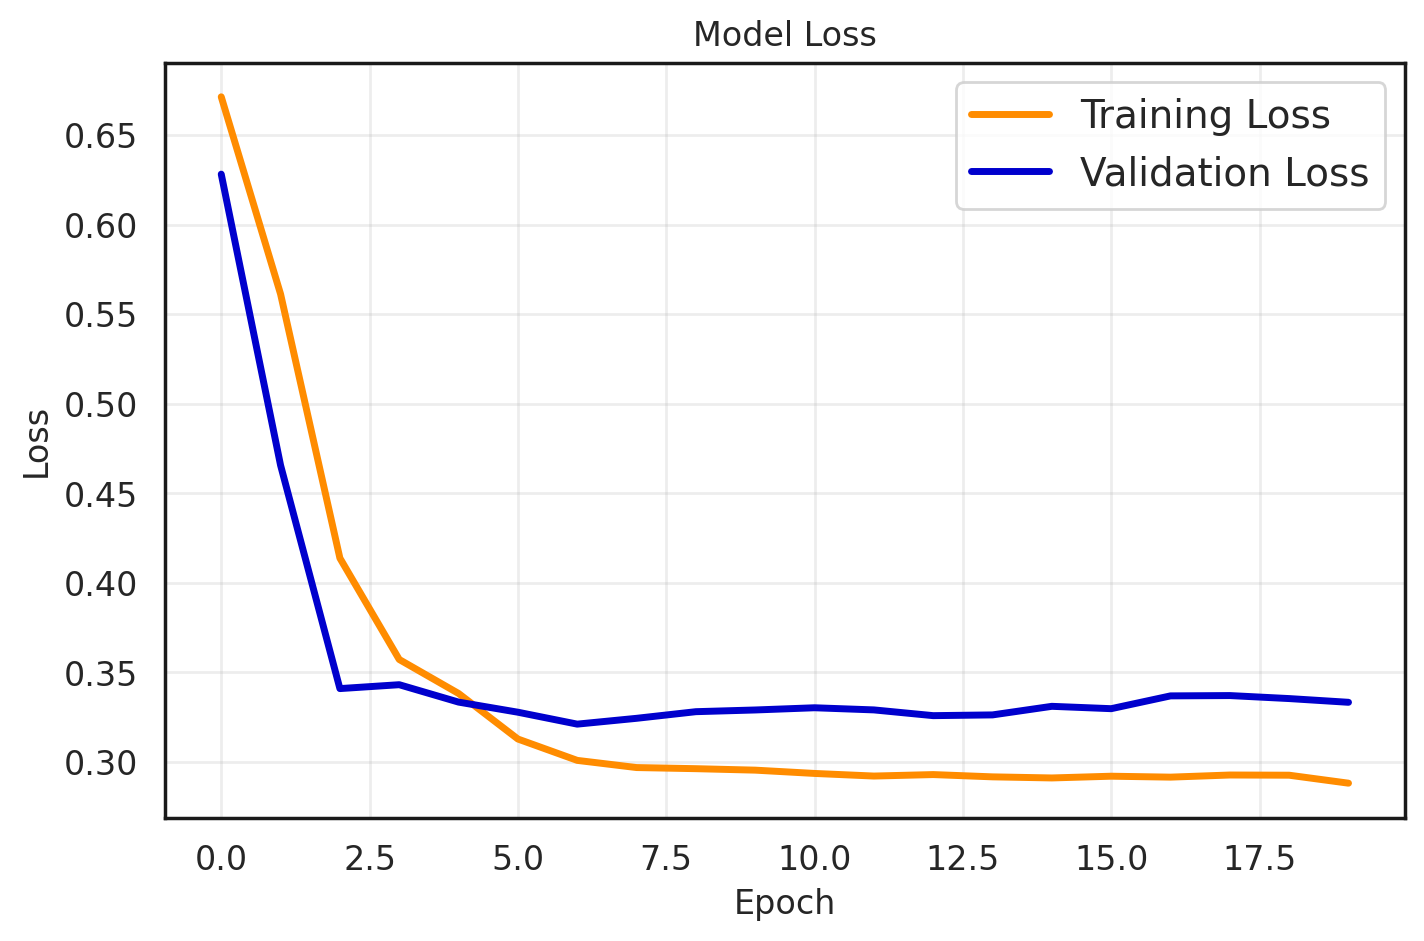

In [ ]:
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline

sns.set(style="whitegrid") # make background white colored 

tickfont = {'family' : 'Times', 'size'   : 12}
labelfont = {'family' : 'Times', 'size'   : 14}

fig = plt.figure(figsize = (8,5), dpi=200) # set figure size and resolution
ax = fig.add_subplot(111)

plt.plot(history.history['loss'], linestyle='-',color='darkorange', linewidth = 2.5, label = 'Training Loss')
plt.plot(history.history['val_loss'], linestyle='-',color='mediumblue', linewidth = 2.5, label = 'Validation Loss')
plt.title('Model Loss')

plt.xticks(**tickfont)
plt.yticks(**tickfont)

plt.grid(b=True, which='major', color='darkgray', linestyle='-',alpha=0.2)

plt.ylabel('Loss')
plt.xlabel('Epoch')

ax.spines['bottom'].set_color('k')
ax.spines['top'].set_color('k') 
ax.spines['right'].set_color('k')
ax.spines['left'].set_color('k')
plt.legend(prop={'size': 14}, loc = 'upper right')
plt.show()

/tmp/ipykernel_1324514/742167719.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='darkgray', linestyle='-',alpha=0.2)


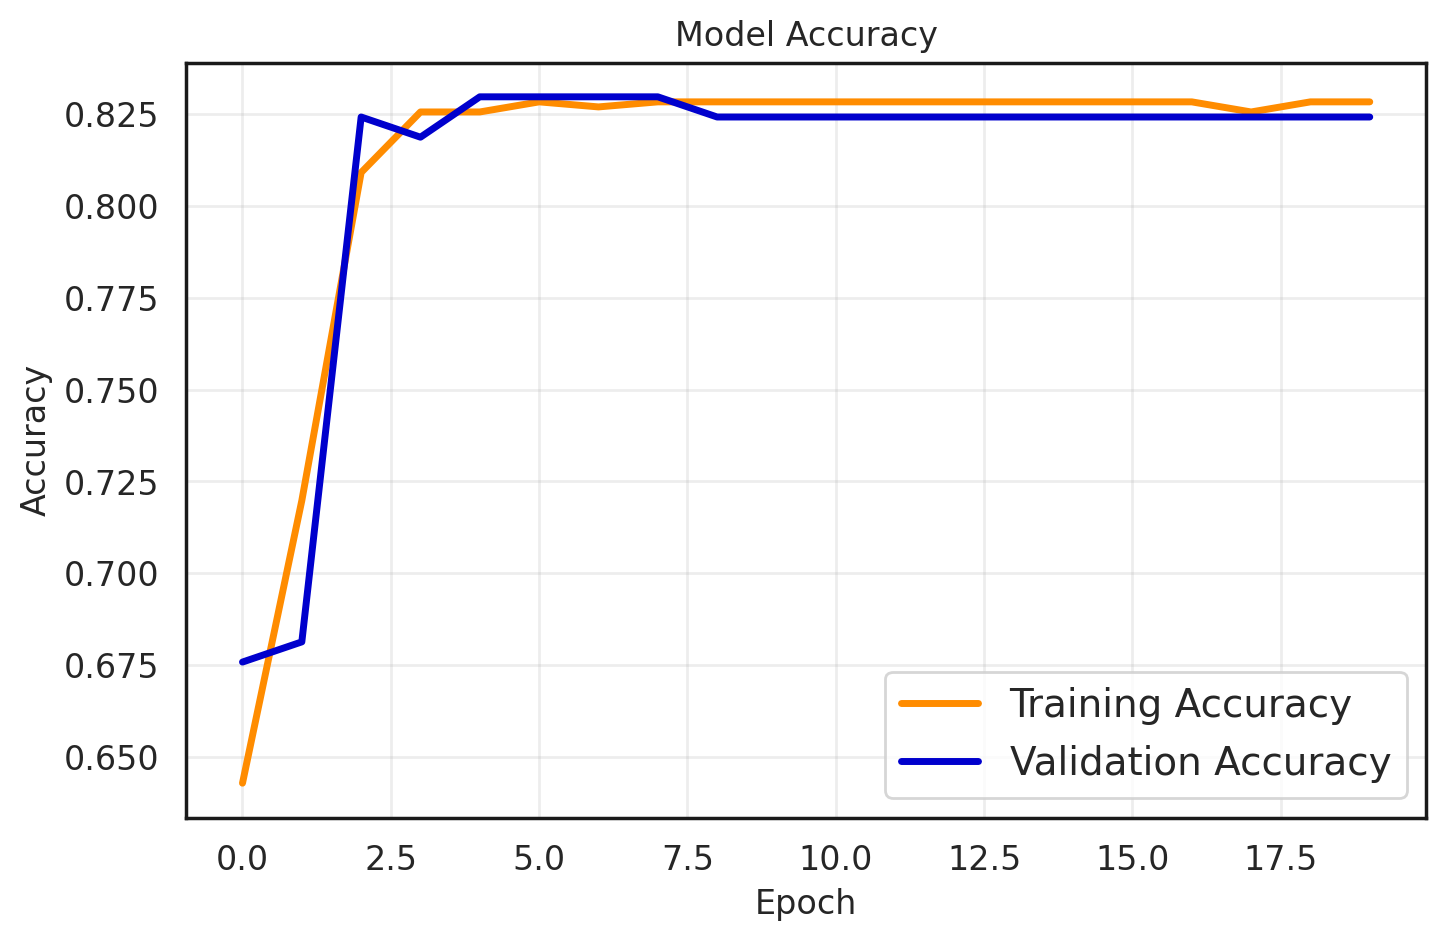

In [ ]:
sns.set(style="whitegrid") # make background white colored 

tickfont = {'family' : 'Times', 'size'   : 12}
labelfont = {'family' : 'Times', 'size'   : 14}

fig = plt.figure(figsize = (8,5), dpi=200) # set figure size and resolution
ax = fig.add_subplot(111)

plt.plot(history.history['binary_accuracy'], linestyle='-',color='darkorange', linewidth = 2.5, label = 'Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], linestyle='-',color='mediumblue', linewidth = 2.5, label = 'Validation Accuracy')
plt.title('Model Accuracy')

plt.xticks(**tickfont)
plt.yticks(**tickfont)

plt.grid(b=True, which='major', color='darkgray', linestyle='-',alpha=0.2)

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

ax.spines['bottom'].set_color('k')
ax.spines['top'].set_color('k') 
ax.spines['right'].set_color('k')
ax.spines['left'].set_color('k')
plt.legend(prop={'size': 14}, loc = 'lower right')
plt.show()

In [ ]:
conf_matrix = confusion_matrix(val_labels, predictions)

In [ ]:
accuracy_score(val_labels, predictions)

NameError: name 'predictions' is not defined

In [ ]:
from sklearn.metrics import f1_score
f1_score(val_labels, predictions)

0.8558758314855875